In [27]:
import math
import cmath
from random import uniform
from scipy.integrate import quad, nquad, dblquad, tplquad
import numpy as np
from numpy import linalg
from scipy import signal
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

epsl = 1e-10

In [2]:
from qiskit import QuantumCircuit, transpile
#from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

## Implement trigonometric polynomial

In [3]:
class MulTriMono:
    def __init__(self, degrees, coefficient):
        self.degrees = degrees
        self.coefficient = coefficient

    def get_degrees(self):
        return self.degrees

    def get_coefficient(self):
        return self.coefficient

    def evaluate(self, x):
        result = self.coefficient
        for i in range(len(self.degrees)):
            result *= np.exp(complex(0,1) * self.degrees[i] * x[i])
        return result

class MulTriPoly:
    def __init__(self, coefficients):
        self.coefficients = coefficients

    def get_coefficients(self):
        return self.coefficients

    def get_coefficient(self, degree):
        return self.coefficients[degree]

    def evaluate(self, x):
        result = 0
        for degree in self.coefficients:
            result += MulTriMono(degree, self.coefficients[degree]).evaluate(x)
        return result

    def add_monomial(self, mono):
        if mono.get_degrees() in self.coefficients:
            self.coefficients[mono.get_degrees()] = self.coefficients[mono.get_degrees()] + mono.get_coefficient()
        else:
            self.coefficients[mono.get_degrees()] = mono.get_coefficient()

In [4]:
def main_function_Jkernel(N, r, t):
    if (t == 0):
        return pow(math.floor(N/2) + 1, 2 * r)
    return pow(np.sin((t/2) * (1 + math.floor(N/2))) / np.sin(t/2) , 2 * r)

def find_lambda(N, r): # we can pre-compute this
    func = lambda t: main_function_Jkernel(N, r, t)
    return quad(func, -math.pi, math.pi, limit=200)[0]

In [5]:
def count_vectors(r, a, b, n): # count vectors z in \mathbb{Z}^r such that a <= z_i <= b and norm_1(z) = n
    if int(2*a) % 2:
        a = int(a + 0.5)
        b = int(b + 0.5)
        n = n + int(r / 2)
    else:
        a = int(a)
        b = int(b)
    if r <= 0:
        return 1 if n == 0 else 0
    m = b - a
    S = n - r * a
    if S < 0 or S > r * m:
        return 0
    total = 0
    max_j = S // (m + 1)
    for j in range(0, max_j + 1):
        sign = -1 if (j % 2 == 1) else 1
        top = S - j * (m + 1) + r - 1
        if top < r - 1:
            continue
        term = math.comb(r, j) * math.comb(top, r - 1)
        total += sign * term
    return total

def m_l(r, l, N):
    return count_vectors(2*r, -math.floor(N/2)/2, math.floor(N/2)/2, l)

def m_nK(n, N, K):
    result = 0
    r = math.ceil((K + 3)/2)
    k = 1
    while (k <= K+1 and k*abs(n) <= r*math.floor(N/2)):
        result += pow(-1, k+1) * math.comb(K+1, k) * m_l(r, k*n, N)
        k += 1
    return result

def tuplem_nK(n, N, K):
    result = 1
    for j in range(len(N)):
        result *= m_nK(n[j], N[j], K[j])
    return result

In [6]:
def fourier_coef(f, at, Nx = 256, Ny = 256): # implement FFT
    x = np.linspace(0, 2*np.pi, Nx, endpoint=False)
    y = np.linspace(0, 2*np.pi, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    func = f(X, Y)
    F = np.fft.fft2(func)
    F = F / (Nx * Ny)

    kx = np.fft.fftfreq(Nx, 1/Nx).astype(int)
    ky = np.fft.fftfreq(Ny, 1/Ny).astype(int)

    i = np.where(kx == at[0])[0][0]
    j = np.where(ky == at[1])[0][0]
    return F[i, j]

In [7]:
def fourier_heat(g, at, t):
    norm = sum([at_i*at_i for at_i in at])
    return np.exp(-norm * t) * fourier_coef(g, at)

In [8]:
from itertools import product

def lattice_points(N):
    ranges = [range(-Nj, Nj+1) for Nj in N]
    return list(product(*ranges))

In [9]:
def mathcalT(f, N, K):
    ld = 1
    tup = ()
    for j in range(len(N)):
        ld *= find_lambda(N[j], math.ceil((K[j]+3)/2))
        tup = tup + (math.ceil((K[j]+3)/2) * math.floor(N[j]/2),)
    trig_poly = MulTriPoly({})

    for n in lattice_points(tup):
        trig_poly.add_monomial(MulTriMono(n, fourier_coef(f, n) * tuplem_nK(n, N, K) * pow(2*math.pi, len(N)) / ld))
    return trig_poly

In [10]:
def mathcalT_heat(g, t, N, K):
    ld = 1
    tup = ()
    for j in range(len(N)):
        ld *= find_lambda(N[j], math.ceil((K[j]+3)/2))
        tup = tup + (math.ceil((K[j]+3)/2) * math.floor(N[j]/2),)
    trig_poly = MulTriPoly({})

    for n in lattice_points(tup):
        trig_poly.add_monomial(MulTriMono(n, fourier_heat(g, n, t) * tuplem_nK(n, N, K) * pow(2*math.pi, len(N)) / ld))
    return trig_poly

## Implement quantum circuit

In [17]:
def create_unitary_matrix(v):
    v = np.array(v, dtype=float).flatten()
    norm_v = np.linalg.norm(v)
    n = len(v)
    v1 = v / norm_v
    U = np.zeros((n, n))
    U[:, 0] = v1
    basis_vectors = np.eye(n)
    if np.allclose(v1, basis_vectors[:, 0]):
        basis_vectors = np.roll(basis_vectors, 1, axis=1)

    for i in range(1, n):
        u = basis_vectors[:, i]
        for j in range(i):
            u = u - np.dot(U[:, j], u) * U[:, j]
        norm_u = np.linalg.norm(u)
        if norm_u < 1e-10:
            raise ValueError("Cannot construct unitary matrix: vectors are linearly dependent")
        U[:, i] = u / norm_u

    return U

def make_VN2(q):
    size = pow(2, q)
    v = np.array([1/math.sqrt(size) for i in range(size)])
    return create_unitary_matrix(v)

def precompute_VN():
    result = []
    for q in range(1, 12):
        result.append(make_VN2(q))
    return result

precomputed_VN = precompute_VN()

def make_VN(q):
    return precomputed_VN[q-1]

def make_CN2(all_U, d, q):
    C_N = np.zeros((pow(2, d+q), pow(2, d+q)), dtype=complex)
    size = pow(2, q)
    for i in range(size):
        vi = np.array([1 if j == i else 0 for j in range(size)])
        C_N += np.kron(np.outer(vi, vi), all_U[i])
    return C_N

def make_CN(all_U, d, q):
    C_N = np.zeros((pow(2, d+q), pow(2, d+q)), dtype=complex)
    size = pow(2, q)
    for i in range(size):
        for j in range(pow(2,d)):
            for k in range(pow(2,d)):
                C_N[pow(2,d)*i + j][pow(2,d)*i + k] = all_U[i][j][k]
    return C_N

def make_U0(d):
    deg = (0,0)
    if d == 3:
        deg = (0,0,0)
    para = find_parameters_from_monomial(MulTriMono(deg, 0))
    qc = QuantumCircuit(d)

    for i in range(d):
        qc.rz(para[i][1][-1], i)
        qc.ry(para[i][0][0], i)
        qc.rz(para[i][1][0], i)

        for j in range(1, len(para[i][0])):
            qc.rz(x, i)
            qc.ry(para[i][0][j], i)
            qc.rz(para[i][1][j], i)
    U0 = Operator(qc).data
    return U0

In [12]:
def make_CN2(all_U, d, q):
    C_N = np.zeros((pow(2, d+q), pow(2, d+q)), dtype=complex)
    size = pow(2, q)
    for i in range(size):
        for j in range(pow(2,d)):
            for k in range(pow(2,d)):
                C_N[pow(2,d)*i + j][pow(2,d)*i + k] = all_U[i][j][k]
    return C_N

In [13]:
class LaurentPoly:
    def __init__(self, degree, coefficients):
        self.coefficients = coefficients
        self.degree = degree

    def get_degree(self):
        return self.degree

    def get_coefficient(self):
        return self.coefficients

    def evaluate(self, x):
        result = self.coefficients[0]
        for i in range(1, self.degree + 1):
            result += self.coefficients[i] * np.exp(complex(0, 1) * i * x / 2)
            result += self.coefficients[-i] * np.exp(-(complex(0, 1) * i * x) / 2)
        return result

    def conjugate(self):
        coefs = [element.conjugate() for element in self.coefficients]
        for n in range(1, self.get_degree() + 1):
            tem = coefs[n]
            coefs[n] = coefs[-n]
            coefs[-n] = tem
        return LaurentPoly(self.degree, coefs)

    def rescale(self, c):
        coefs = [element / c for element in self.coefficients]
        return LaurentPoly(self.degree, coefs)

    def lower_deg_by_2(self):
        deg = self.degree
        new_deg = deg - 2
        new_coefs = [0] * (new_deg * 2 + 1)
        for i in range(-new_deg, new_deg + 1):
            new_coefs[i] = self.coefficients[i]
        return LaurentPoly(new_deg, new_coefs)

    def minus_by_one(self):
        coefs = [0] * (self.degree * 2 + 1)
        for i in range(- self.degree, self.degree + 1):
            coefs[i] = - self.coefficients[i]
            if i == 0:
                coefs[i] += 1
        return LaurentPoly(self.degree, coefs)

    def __add__(self, other):
        P = self
        Q = other
        if Q.get_degree() < P.get_degree():
            P, Q = Q, P
        coefs = Q.get_coefficient()
        for i in range(- P.get_degree(), P.get_degree() + 1):
            coefs[i] += P.get_coefficient()[i]
        return LaurentPoly(Q.get_degree(), coefs)

    def __mul__(self, other):
        P = self
        Q = other
        coefs = [0] * ((P.get_degree() + Q.get_degree())*2 + 1)
        for i in range(- P.get_degree(), P.get_degree() + 1):
            for j in range(- Q.get_degree(), Q.get_degree() + 1):
                coefs[i+j] += P.get_coefficient()[i] * Q.get_coefficient()[j]
        return LaurentPoly(P.get_degree() + Q.get_degree(), coefs)

class Polynomial:
    def __init__(self, coefficients):
        self.coefficients = list(coefficients)
        self.degree = len(coefficients) - 1

    def get_degree(self):
        return self.degree

    def get_coefficient(self):
        return self.coefficients

    def evaluate(self, x):
        result = 0
        for i in range(self.degree + 1):
            result += self.coefficients[i] * math.pow(x, i)
        return result

    def find_roots(self):
        return np.roots(self.coefficients[::-1])

    def __repr__(self):
        terms = []
        for i, coef in enumerate(self.coefficients):
            if coef != 0:
                if i == 0:
                    terms.append(f"{coef}")
                elif i == 1:
                    terms.append(f"{coef}x")
                else:
                    terms.append(f"{coef}x^{i}")
        return " + ".join(terms) if terms else "0"

    def __mul__(self, other):
        deg_P = self.degree
        deg_Q = other.degree
        coefs_P = self.coefficients
        coefs_Q = other.coefficients

        result_coefs = [0] * (deg_P + deg_Q + 1)
        for i in range(deg_P + 1):
            for j in range(deg_Q + 1):
                result_coefs[i + j] += coefs_P[i] * coefs_Q[j]

        return Polynomial(result_coefs)

In [14]:
def pair_conjugates(roots):
    result = []
    matched = [0] * len(roots)
    for i in range(len(roots)):
        if matched[i]:
            continue
        matched[i] = 1
        simi_score = 100
        for j in range(len(roots)):
            if matched[j]:
                continue
            if abs(1/roots[i].conjugate() - roots[j]) < simi_score:
                cur_ind = j
                simi_score = abs(1/roots[i].conjugate() - roots[j])
        result.append([roots[i], roots[cur_ind]])
        matched[cur_ind] = 1
    return result

def find_Q(P):
    A = (P * P.conjugate()).minus_by_one() #oneminus(multiply(P, P.conjugate()))
    deg = A.get_degree()

    while (deg >= 0):
        if abs(A.get_coefficient()[deg]) < epsl:
            deg -= 1
        else:
            break
    if deg == -1:
        return LaurentPoly(0, [0])
    coefs = [0] * (2*deg + 1)
    for n in range(2*deg + 1):
        coefs[n] = A.get_coefficient()[-deg + n] / A.get_coefficient()[deg]
    B = Polynomial(coefs)
    roots = B.find_roots()
    conj_pairs = pair_conjugates(roots)
    const = A.get_coefficient()[deg]
    C = Polynomial([1])
    for i in range(deg):
        const *= conj_pairs[i][0]
        C = C * Polynomial([-conj_pairs[i][1], 1])
    const = math.sqrt(const.real)
    coefs_Q = [0] * (deg + 1)
    for n in range(-int(deg/2), int(deg/2) + 1):
        coefs_Q[n] = C.get_coefficient()[n+int(deg/2)] * const
    Q = LaurentPoly(int(deg/2), coefs_Q)
    if np.round((Q * Q.conjugate() + P * P.conjugate()).get_coefficient()[0]) - 1 > epsl:
        print("Warning: Incompatible value of N. Try restricting N <= 27")
    return Q

def find_parameters(P, Q):
    M = P.get_degree()
    theta = [0] * (M+1)
    phi = [0] * (M+2)

    if Q.get_degree() == 0 and abs(Q.get_coefficient()[0]) < epsl and abs(P.get_coefficient()[M]) > 0: # and power is pos
        if M != 0:
            theta[0] = 3 * math.pi
            theta[M] = math.pi
        return theta, phi

    if Q.get_degree() == 0 and abs(Q.get_coefficient()[0]) < epsl and abs(P.get_coefficient()[M]) < epsl: # and power is neg
        return theta, phi


    if Q.get_degree() == 0 and abs(Q.get_coefficient()[0] > epsl) and abs(P.get_coefficient()[M]) < epsl: # power is neg and const is non zero
        theta[0] = 2 * math.acos(abs(P.get_coefficient()[-M]))
        phi[0] = cmath.phase(Q.get_coefficient()[0]) - cmath.phase(P.get_coefficient()[-M])
        phi[-1] = - cmath.phase(Q.get_coefficient()[0]) - cmath.phase(P.get_coefficient()[-M])
        return theta, phi

    newP, newQ = P, Q

    # power is pos and const is non zero
    for i in range(M, 0, -1):

        if i > M/2:
            if i == M:
                theta[i] = math.pi
                newP, newQ = LaurentPoly(1, [0, Q.get_coefficient()[0], 0]), (newP * LaurentPoly(1, [0, 0, -1])).lower_deg_by_2()
            else:
                newP, newQ = newP * LaurentPoly(1, [0, 1, 0]), (newQ * LaurentPoly(1, [0, 0, 1])).lower_deg_by_2()
        elif i == M/2:

            z = (-newP.get_coefficient()[i]) / newQ.get_coefficient()[i]
            theta[i] = 2*math.atan(abs(z))
            phi[i] = -cmath.phase(z / math.tan(theta[i]/2))


            newP, newQ = (newP * LaurentPoly(1, [0, np.exp(complex(0,1)*phi[i]/2) * np.cos(theta[i]/2), 0]) + newQ * LaurentPoly(1, [0, np.exp( - complex(0,1)*phi[i]/2) * np.sin(theta[i]/2), 0])).lower_deg_by_2(), (newP * LaurentPoly(1, [0, 0, -np.exp(complex(0,1)*phi[i]/2) * np.sin(theta[i]/2)]) + newQ * LaurentPoly(1, [0, 0, np.exp(-complex(0,1)*phi[i]/2) * np.cos(theta[i]/2)])).lower_deg_by_2()

            tem = - newQ.get_coefficient()[i-1]

            theta[0] = 3*math.pi
            phi[0] = cmath.phase(tem)
            phi[-1] = - cmath.phase(tem)

            return theta, phi

    theta[0] = 2 * math.acos(abs(P.get_coefficient()[-M]))
    phi[0] = cmath.phase(Q.get_coefficient()[0]) - cmath.phase(P.get_coefficient()[-M])
    phi[-1] = - cmath.phase(Q.get_coefficient()[0]) - cmath.phase(P.get_coefficient()[-M])
    return theta, phi


In [15]:
def find_parameters_from_monomial(t):
    para = []
    for i in range(len(t.get_degrees())):
        deg = t.get_degrees()[i] * 2
        coefs = [0] * (abs(deg) * 2 + 1)
        if i == 0:
            coefs[deg] = t.get_coefficient()
        else:
            coefs[deg] = 1
        P = LaurentPoly(abs(deg), coefs)
        Q = find_Q(P)
        para.append(find_parameters(P, Q))
    return para

def find_parameters_from_polynomial(T):
    para = {}
    for degree in T.get_coefficients():
        t = MulTriMono(degree, T.get_coefficient(degree))
        para[degree] = find_parameters_from_monomial(t)
    return para


In [16]:

def multiqbqnn(trig_poly, x):
    d = len(x)

    all_U = []
    all_paras = find_parameters_from_polynomial(trig_poly)

    tt = time.time()
    for degree in all_paras:

        qc = QuantumCircuit(d)
        para = all_paras[degree]
        for i in range(d):

            qc.rz(para[i][1][-1], i)
            qc.ry(para[i][0][0], i)
            qc.rz(para[i][1][0], i)

            for j in range(1, len(para[i][0])):
                qc.rz(x[i], i)
                qc.ry(para[i][0][j], i)
                qc.rz(para[i][1][j], i)
        U_n = Operator(qc).data
        all_U.append(U_n)


    N = len(all_U)
    q = math.ceil(math.log2(N))

    for i in range(N, pow(2, q)):
        all_U.append(make_U0(d))

    CN = make_CN(all_U, d, q)
    VN = make_VN(q)

    qc = QuantumCircuit(d+q)
    ancilla = [i for i in range(d, d+q)]

    qc.append(Operator(VN), ancilla)
    qc.append(Operator(CN), [i for i in range(0, q+d)])
    qc.append(Operator(VN.conj().T), ancilla)

    sv = Statevector.from_instruction(qc)

    return sv.data[0] * pow(2, q)

## Testing

In [45]:
x = (0.11, 0.48)
f = lambda x1, x2: np.sin(x1) * np.sin(x2/2)

N = (1, 1)
K = (0, 0)
trig_poly = mathcalT(f, N, K)

print(multiqbqnn(trig_poly, x))
print(trig_poly.evaluate(x))
print(f(x[0], x[1]))

CircuitError: 'The amount of qubit(0)/clbit(0) arguments does not match the gate expectation (11).'

## Plot (heat equation)

In [30]:
g = lambda x1, x2: np.sin(x1) * np.sin(x2/2) # inital value

In [20]:
def heat_solution_fft(g_func, t, x_point, N=128):

    x1, x2 = x_point

    grid = np.linspace(0, 2*np.pi, N, endpoint=False)
    X, Y = np.meshgrid(grid, grid, indexing="ij")
    G = g_func(X, Y)

    G_hat = np.fft.fft2(G) / (N**2)
    k = np.fft.fftfreq(N, d=1.0/N)  
    KX, KY = np.meshgrid(k, k, indexing="ij")

    decay = np.exp(-(KX**2 + KY**2) * t)

    phase = np.exp(1j * (KX*x1 + KY*x2))
    u_val = np.sum(G_hat * decay * phase)

    return np.real(u_val)

In [24]:
def make_plot(t):
    N = (10,10)
    K = (0,0)

    trig_poly = mathcalT_heat(g, t, N, K)

    div = 30

    x = np.linspace(0, 2*np.pi, div)
    y = np.linspace(0, 2*np.pi, div)
    X, Y = np.meshgrid(x, y, indexing="ij")

    U_1 = np.zeros_like(X)
    U_2 = np.zeros_like(X)
    for i in range(div):
        for j in range(div):
            if t == 0:
                U_1[i,j] = g(X[i,j], Y[i,j])
            else:
                U_1[i,j] = heat_solution_fft(g, t, (X[i,j], Y[i,j]))
            U_2[i,j] = multiqbqnn(trig_poly, (X[i,j], Y[i,j])).real

    #vmin = min(U_1.min(), U_2.min())
    #vmax = max(U_1.max(), U_2.max())

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # True solution
    c1 = axes[0].contourf(X, Y, U_1, levels=50, cmap="inferno", vmin=-1, vmax=1)
    fig.colorbar(c1, ax=axes[0])
    axes[0].set_title(str("True solution u(x,t), t = " + str(t)))
    axes[0].set_xlabel("x1")
    axes[0].set_ylabel("x2")

    # Estimator
    c2 = axes[1].contourf(X, Y, U_2, levels=50, cmap="inferno", vmin=-1, vmax=1)
    fig.colorbar(c2, ax=axes[1])
    axes[1].set_title(str("QNN Estimator for t = " + str(t)))
    axes[1].set_xlabel("x1")
    axes[1].set_ylabel("x2")

    plt.tight_layout()
    plt.show()

In [47]:
def make_plot_3d(t):
    N = (8,8)
    K = (1,1)

    trig_poly = mathcalT_heat(g, t, N, K)

    div = 50

    x = np.linspace(0, 2*np.pi, div)
    y = np.linspace(0, 2*np.pi, div)
    X, Y = np.meshgrid(x, y, indexing="ij")

    U_1 = np.zeros_like(X)
    U_2 = np.zeros_like(X)
    for i in range(div):
        for j in range(div):
            if t == 0:
                U_1[i,j] = g(X[i,j], Y[i,j])
            else:
                U_1[i,j] = heat_solution_fft(g, t, (X[i,j], Y[i,j]))
            U_2[i,j] = multiqbqnn(trig_poly, (X[i,j], Y[i,j])).real
    fig = plt.figure(figsize=(12,5))

    # True solution
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, U_1, cmap="viridis")
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    ax1.set_title(str("True solution u(x,t), t = " + str(t)))
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    ax1.set_zlabel("u")

    # Estimator
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, U_2, cmap="plasma")
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    ax2.set_title(str("QNN Estimator, t = " + str(t)))
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    ax2.set_zlabel("u")

    plt.tight_layout()
    plt.show()

In [67]:
def compare_N(t = 0.5, maxN = 10, div = 30):
    out = []
    K = (0,0)
    for n1 in range(2, maxN+1):
        for n2 in range(2, maxN+1):
            N = (n1,n2)

            trig_poly = mathcalT_heat(g, t, N, K)

            x = np.linspace(0, 2*np.pi, div)
            y = np.linspace(0, 2*np.pi, div)
            X, Y = np.meshgrid(x, y, indexing="ij")
            err = []

            for i in range(div):
                for j in range(div):
                    err.append(abs(heat_solution_fft(g, t, (X[i,j], Y[i,j])) - multiqbqnn(trig_poly, (X[i,j], Y[i,j])).real))
                    
            out.append(max(err))
            print(n1, n2, "done")

    N1 = list(range(2, maxN+1))  
    N2 = list(range(2, maxN+1))  

    X, Y = np.meshgrid(N1, N2)
    Z = np.array(out).reshape(len(N1), len(N2))

    plt.figure(figsize=(6, 5))
    plt.imshow(Z, origin='lower', cmap='viridis', extent=[min(N1), max(N1), min(N2), max(N2)], aspect='auto')

    # Add colorbar and labels
    plt.colorbar(label='out')
    plt.xlabel('N_1')
    plt.ylabel('N_2')
    plt.title('Heat map of error vs. N')

    plt.show()

2 2 done
2 3 done
2 4 done
2 5 done
2 6 done
2 7 done
2 8 done
2 9 done
2 10 done
3 2 done
3 3 done
3 4 done
3 5 done
3 6 done
3 7 done
3 8 done
3 9 done
3 10 done
4 2 done
4 3 done
4 4 done
4 5 done
4 6 done
4 7 done
4 8 done
4 9 done
4 10 done
5 2 done
5 3 done
5 4 done
5 5 done
5 6 done
5 7 done
5 8 done
5 9 done
5 10 done
6 2 done
6 3 done
6 4 done
6 5 done
6 6 done
6 7 done
6 8 done
6 9 done
6 10 done
7 2 done
7 3 done
7 4 done
7 5 done
7 6 done
7 7 done
7 8 done
7 9 done
7 10 done
8 2 done
8 3 done
8 4 done
8 5 done
8 6 done
8 7 done
8 8 done
8 9 done
8 10 done
9 2 done
9 3 done
9 4 done
9 5 done
9 6 done
9 7 done
9 8 done
9 9 done
9 10 done
10 2 done
10 3 done
10 4 done
10 5 done
10 6 done
10 7 done
10 8 done
10 9 done
10 10 done


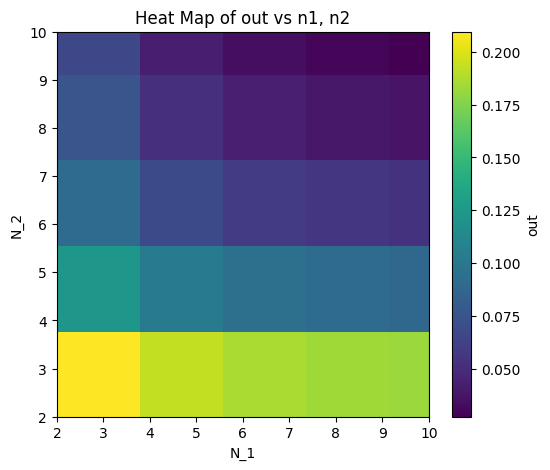

In [68]:
compare_N(0.5, 10, 5) # set maxN = 10 to run from (2,2) to (10,10), if it takes too long, reduce div from 50 to 30